# <center> 7. Linear Regression </center>

- Data import and transformations
- Linear regression
- Linear regression with dummy variables

In [54]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.tseries.holiday import USFederalHolidayCalendar

In [55]:
##### Jupyter notebook theme setup:
# !pip install jupyterthemes
!jt -t gruvboxd -fs 95 -tfs 11 -nfs 115 -cellw 80% -T
##### Reset theme:
# !jt -r
##### Plot style:
from jupyterthemes import jtplot
jtplot.style()

# Reload page after cell evaluation

# Data Import

In [56]:
passers = pd.read_csv('data/passerbys.csv', sep=',')
weather = pd.read_csv('data/weather.csv',   sep=',')

In [57]:
passers.tail(3)

,Date,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
59085,2012-10-03 02:00:00,1.0,1.0
59086,2012-10-03 01:00:00,4.0,6.0
59087,2012-10-03 00:00:00,4.0,9.0


In [58]:
weather.head(3)

,DATE,TAVG,PRCP
0,2000-01-01,4.4,6.9
1,2000-01-02,-3.9,0.0
2,2000-01-03,5.6,7.1


# Data Transformations

In [59]:
passers['Date'] = pd.to_datetime(passers['Date'])
passers = passers.set_index('Date')
passers.head(3)

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,
2019-06-30 23:00:00,7.0,15.0
2019-06-30 22:00:00,20.0,30.0
2019-06-30 21:00:00,31.0,32.0


In [60]:
weather = weather.rename(columns={'DATE': 'Date'})
weather['Date'] = pd.to_datetime(weather['Date'])
weather = weather.set_index('Date')
weather.head(3)

,TAVG,PRCP
Date,,
2000-01-01,4.4,6.9
2000-01-02,-3.9,0.0
2000-01-03,5.6,7.1


In [61]:
# Sum by day
passers = passers.resample('1D').sum()
passers.head(3)

,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,
2012-10-03,1760.0,1761.0
2012-10-04,1708.0,1767.0
2012-10-05,1558.0,1590.0


In [62]:
data = passers.join(weather, how='left')

In [63]:
# All NA in TAVG are in the begining of series, so could be excluded
data = data[~(data['TAVG'].isna())]

In [64]:
data = data.fillna(0)
# Short names
data = data.rename(columns={'Fremont Bridge East Sidewalk': 'East', 'Fremont Bridge West Sidewalk': "West"})
# Sum of pedastrians to be predicted
data['Walkers'] = data['East'] + data['West']

In [65]:
data.tail(5)

,East,West,TAVG,PRCP,Walkers
Date,,,,,
2019-06-24,1862.0,3086.0,14.7,0.0,4948.0
2019-06-25,2294.0,3766.0,16.6,0.0,6060.0
2019-06-28,1753.0,3044.0,16.1,0.0,4797.0
2019-06-29,1435.0,1748.0,18.0,0.0,3183.0
2019-06-30,1541.0,1993.0,19.8,0.0,3534.0


In [66]:
# Dummy variable for each day of week

days = data.index.to_series().dt.dayofweek
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
data = (
    data.join(pd.DataFrame({day_names[x]: (days == x).astype(int) for x in range(0, 7)}, index=days.index))
)

In [67]:
data.head(10)

,East,West,TAVG,PRCP,Walkers,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,,,,,
2013-04-01,1654.0,1594.0,12.8,0.0,3248.0,1,0,0,0,0,0,0
2013-04-02,1685.0,1602.0,11.5,0.0,3287.0,0,1,0,0,0,0,0
2013-04-03,1739.0,1747.0,11.7,0.0,3486.0,0,0,1,0,0,0,0
2013-04-04,1016.0,991.0,12.0,8.4,2007.0,0,0,0,1,0,0,0
2013-04-05,914.0,928.0,12.2,18.5,1842.0,0,0,0,0,1,0,0
2013-04-06,429.0,360.0,9.8,12.7,789.0,0,0,0,0,0,1,0
2013-04-07,314.0,263.0,7.2,39.1,577.0,0,0,0,0,0,0,1
2013-04-08,1334.0,1355.0,7.7,0.8,2689.0,1,0,0,0,0,0,0
2013-04-09,1504.0,1396.0,9.1,0.0,2900.0,0,1,0,0,0,0,0


In [68]:
# Dummy for holidays

In [69]:
calendar = USFederalHolidayCalendar()
holidays_us = calendar.holidays(start=data.index.min(), end=data.index.max())

In [70]:
data['NotBusiness'] = pd.DataFrame([1] * len(holidays_us), index=holidays_us)

In [71]:
# Dummy for weekends
data.loc[(data.index.dayofweek == 5) | (data.index.dayofweek == 6), 'NotBusiness'] = 1

# Sun and Sat must be excluded from model now

In [72]:
data['NotBusiness'] = data['NotBusiness'].fillna(0)

In [73]:
data.head(10)

,East,West,TAVG,PRCP,Walkers,Mon,Tue,Wed,Thu,Fri,Sat,Sun,NotBusiness
Date,,,,,,,,,,,,,
2013-04-01,1654.0,1594.0,12.8,0.0,3248.0,1,0,0,0,0,0,0,0.0
2013-04-02,1685.0,1602.0,11.5,0.0,3287.0,0,1,0,0,0,0,0,0.0
2013-04-03,1739.0,1747.0,11.7,0.0,3486.0,0,0,1,0,0,0,0,0.0
2013-04-04,1016.0,991.0,12.0,8.4,2007.0,0,0,0,1,0,0,0,0.0
2013-04-05,914.0,928.0,12.2,18.5,1842.0,0,0,0,0,1,0,0,0.0
2013-04-06,429.0,360.0,9.8,12.7,789.0,0,0,0,0,0,1,0,1.0
2013-04-07,314.0,263.0,7.2,39.1,577.0,0,0,0,0,0,0,1,1.0
2013-04-08,1334.0,1355.0,7.7,0.8,2689.0,1,0,0,0,0,0,0,0.0
2013-04-09,1504.0,1396.0,9.1,0.0,2900.0,0,1,0,0,0,0,0,0.0


# Visualization

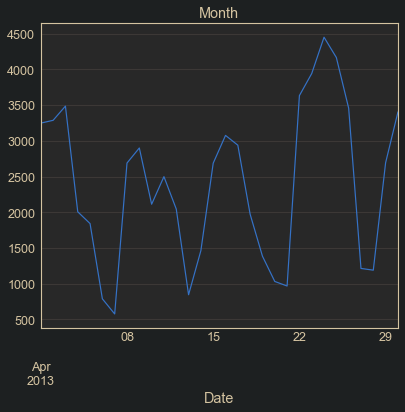

In [78]:
data['Walkers'][:30].plot(title='Month');

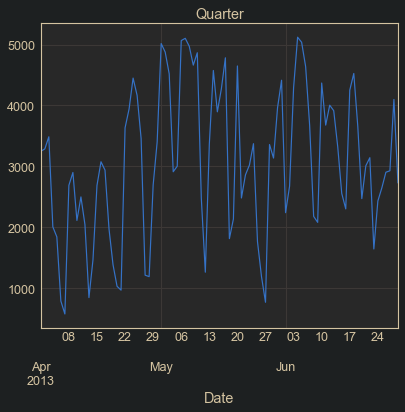

In [77]:
data['Walkers'][:90].plot(title='Quarter');

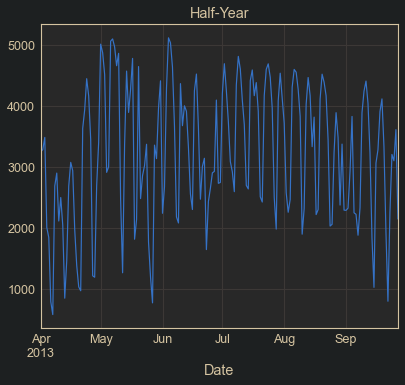

In [79]:
data['Walkers'][:180].plot(title='Half-Year');

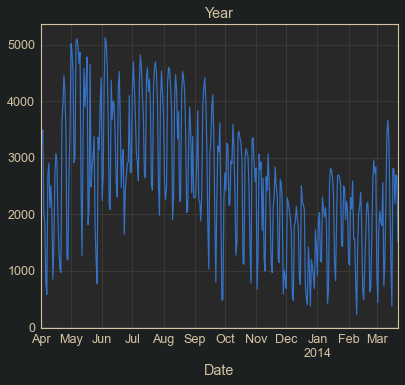

In [80]:
data['Walkers'][:356].plot(title='Year');

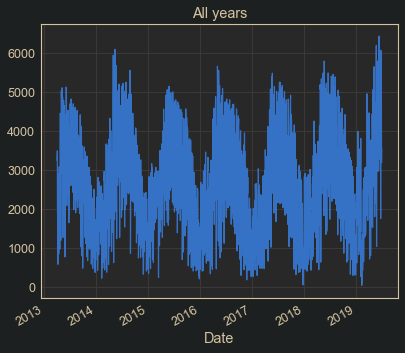

In [81]:
data['Walkers'].plot(title='All years');

On plots one can see weekly and monthly periods.
But probably the reason of it is temperature changes, so we wont consider monthly dummies.

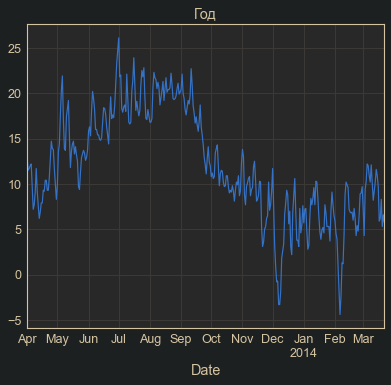

In [82]:
data['TAVG'][:356].plot(title='Год');

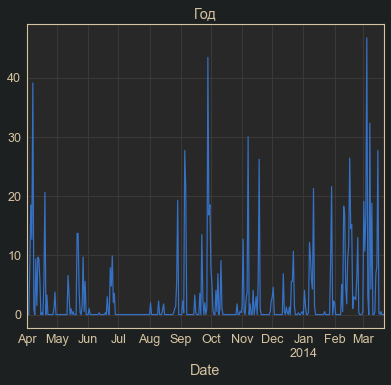

In [84]:
data['PRCP'][:356].plot(title='Год');

# Regression models

## 1. Model with no holidays

In [86]:
results = smf.ols('Walkers ~ TAVG + PRCP + Tue + Wed + Thu + Fri + Sat + Sun', data=data).fit()
print(results.summary())

# NB! One of dummy variables was dropped, because of multicollinearity

                            OLS Regression Results                            
Dep. Variable:                Walkers   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     947.5
Date:                Wed, 02 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:16:39   Log-Likelihood:                -17977.
No. Observations:                2280   AIC:                         3.597e+04
Df Residuals:                    2271   BIC:                         3.602e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1868.0926     46.475     40.196      0.0

All parameters but Tue are significant
Lets try to exclude Tue

In [87]:
results = smf.ols('Walkers ~ TAVG + PRCP + Wed + Thu + Fri + Sat + Sun', data=data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Walkers   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     1068.
Date:                Wed, 02 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:17:11   Log-Likelihood:                -17990.
No. Observations:                2280   AIC:                         3.600e+04
Df Residuals:                    2272   BIC:                         3.604e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1993.2325     39.495     50.467      0.0

All parameters are significant. Hypotesis of insignificance of parameters Wed and Thu is rejected on significance level 0.05.

Durbin-Watson criteria looks not so well, so autocorelation of residuals is possible..

$R^2$ looks nice.

F-statistic lets us reject hypotesis of insignificance of regression.

In saturday and sunday there are much more less walkets, than in monday ($\approx -1800$).

## 2. Model with Holidays

In [88]:
results = smf.ols('Walkers ~ TAVG + PRCP + NotBusiness', data=data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Walkers   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     2612.
Date:                Wed, 02 Jun 2021   Prob (F-statistic):               0.00
Time:                        13:20:28   Log-Likelihood:                -17950.
No. Observations:                2280   AIC:                         3.591e+04
Df Residuals:                    2276   BIC:                         3.593e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    2001.8308     34.183     58.562      

There are no big changes.

But better $R^2$ was achieved using less number of parameters.

In holidays and weekends, in average, there are $-1735$ less walkers. Maybe bridges are located not in recreational zone, but on the way to work for many people.